# **INTRODUCTION**
This is the second part of my TTC Subway Delay project.

**Dataset**

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress
import textwrap
import calendar

In [126]:
df_master = pd.read_excel('Excel Files/df_master.xlsx')
df_master

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,station_clean,line_clean,datetime,time_period,delay_cause,delay_category
0,2024-01-01,02:00,Monday,SHEPPARD STATION,MUI,0,0,N,YU,5491,Sheppard-Yonge,Lines 1 and 4 Shared,2024-01-01 02:00:00,early_morning,Injured or ill Customer (On Train) - Transported,Passenger Related
1,2024-01-01,02:00,Monday,DUNDAS STATION,MUIS,0,0,N,YU,0,Dundas,Line 1 Yonge-University,2024-01-01 02:00:00,early_morning,Injured or ill Customer (In Station) - Transpo...,Passenger Related
2,2024-01-01,02:08,Monday,DUNDAS STATION,MUPAA,4,10,N,YU,6051,Dundas,Line 1 Yonge-University,2024-01-01 02:08:00,early_morning,Passenger Assistance Alarm Activated - No Trou...,Passenger Related
3,2024-01-01,02:13,Monday,KENNEDY BD STATION,PUTDN,10,16,E,BD,5284,Kennedy,Lines 2 and 3 Shared,2024-01-01 02:13:00,early_morning,Debris At Track Level - Uncontrollable,Fortuitous Event
4,2024-01-01,02:22,Monday,BLOOR STATION,MUPAA,4,10,N,YU,5986,Bloor-Yonge,Lines 1 and 2 Shared,2024-01-01 02:22:00,early_morning,Passenger Assistance Alarm Activated - No Trou...,Passenger Related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214456,2017-04-30,19:50,Sunday,BLOOR DANFORTH SUBWAY,MUO,0,0,NaN,BD,0,Bloor-Yonge,Lines 1 and 2 Shared,2017-04-30 19:50:00,evening,Miscellaneous Other,Undefined
214457,2017-04-30,20:25,Sunday,WARDEN STATION,SUDP,4,8,W,BD,5107,Warden,Line 2 Bloor-Danforth,2017-04-30 20:25:00,evening,Disorderly Patron,Passenger Related
214458,2017-04-30,20:29,Sunday,KEELE STATION,SUROB,0,0,NaN,BD,0,Keele,Line 2 Bloor-Danforth,2017-04-30 20:29:00,evening,Robbery,Passenger Related
214459,2017-04-30,22:00,Sunday,YONGE UNIVERSITY LINE,MUO,0,0,NaN,YU/BD,0,Bloor-Yonge,Lines 1 and 2 Shared,2017-04-30 22:00:00,evening,Miscellaneous Other,Undefined


# **EXPLORATORY DATA ANALYSIS**

## Functions and Loops

We'll define some functions here that will speed up our EDA.

In [127]:
# we'll create a dataframe for each delay cause, to help us in creating the charts later
for cause in df_master['delay_cause'].unique():
    if not isinstance(cause, str):
        continue
    subset = df_master[df_master['delay_cause'] == cause]
    cause_df = subset
    # rename each category_df accordingly
    variable_name = cause.replace(" ", "_").replace("/", "_").replace("-", "_")
    globals()[variable_name] = cause_df

In [128]:
# for a consistent color-scheme per category, we're creating a dictionary here
colors = {'Personnel Related': 'red',
          'Equipment Related': 'orange',
          'Passenger Related': 'green',
          'Fortuitous Event': 'purple',
          'Undefined': 'gray'}

In [129]:
# we'll create a dataframe for each delay category, to help us in creating the charts later
for category in df_master['delay_category'].unique():
    if not isinstance(category, str):
        continue
    subset = df_master[df_master['delay_category'] == category]
    category_df = subset
    # rename each category_df accordingly
    variable_name = category.replace(" ", "_").replace("/", "_").replace("-", "_")
    globals()[variable_name] = category_df

In [130]:
# create bar chart (time period)
def create_bar_chart(delay_cause,
                     title = None):
    grouped_data = delay_cause.groupby(['time_period']).agg(
        total_occurrence = ('Min Delay', 'count'),
        delay_duration = ('Min Delay', 'sum')).reset_index()
    
    plt.figure(figsize = (12,5))
    x = np.arange(len(grouped_data['time_period']))
    bars1 = plt.bar(x - 0.35/2,
        grouped_data['delay_duration'],
        0.35,
        label = 'Delay Duration (in Minutes)')
    bars2 = plt.bar(x + 0.35/2,
        grouped_data['total_occurrence'],
        0.35,
        label = 'Delay Occurrence (Count)',
        color = 'orange')

    # Annotate the bars
    for bar in bars1:
        plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height(), 
             f'{bar.get_height():.0f} (Minutes)', 
             ha = 'center', va = 'bottom', fontsize = 10)

    for bar in bars2:
        plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height(), 
             f'{bar.get_height():.0f} (Count)', 
             ha = 'center', va = 'bottom', fontsize = 10)
        
    # Add labels and title
    plt.title(title)
    plt.xlabel('Time Period')
    plt.xticks(x, grouped_data['time_period'])
    plt.legend()
    plt.tight_layout()
    plt.show()

In [154]:
# create histogram on Min Delay
def create_histogram(delay_cause,
                     title = None):
        plt.figure(figsize = (15, 2))
        plt.hist(delay_cause['Min Delay'], 
             bins = 100, 
             color = 'blue', 
             edgecolor = 'black', 
             alpha = 0.7)
        plt.title(title)
        plt.xlabel('Delay Duration (in Minutes)')
        plt.ylabel('Frequency')
        plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
        plt.show()

## Daily Delay Occurrences

Delay Occurrences is the count or number of recorded delays in a given time period.

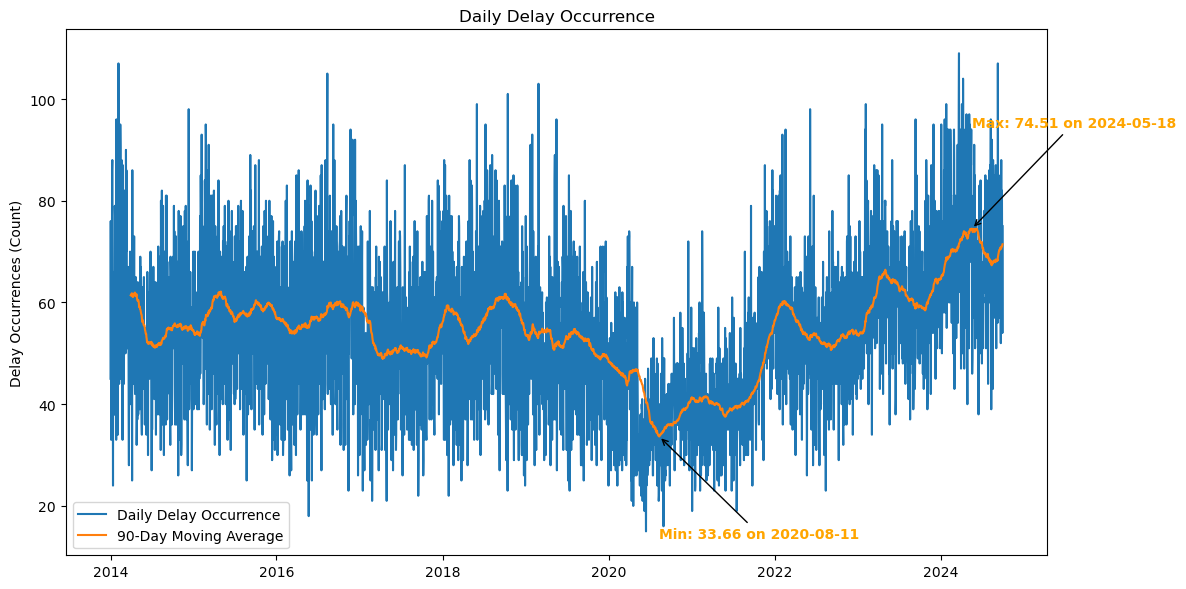

In [131]:
# group by date and count the delay occurrences
daily_delay_occurrence = df_master.groupby('Date')['Min Delay'].count().reset_index()
# compute the 90-day moving average
daily_delay_occurrence['MA90'] = daily_delay_occurrence['Min Delay'].rolling(window = 90).mean()

# create the line chart
plt.figure(figsize = (12,6))
plt.plot(daily_delay_occurrence['Date'], 
         daily_delay_occurrence['Min Delay'], 
         label = 'Daily Delay Occurrence')
plt.plot(daily_delay_occurrence['Date'], 
         daily_delay_occurrence['MA90'], 
         label = '90-Day Moving Average')
plt.title('Daily Delay Occurrence')
plt.ylabel('Delay Occurrences (Count)')

# annotate max values
max_date = daily_delay_occurrence.loc[daily_delay_occurrence['MA90'].idxmax(), 'Date']
max_delay = daily_delay_occurrence['MA90'].max()
plt.annotate(f'Max: {max_delay:.2f} on {max_date.strftime("%Y-%m-%d")}',
             xy = (max_date, max_delay), 
             xytext = (max_date, max_delay + 20),
             arrowprops = dict(arrowstyle = '->'), 
             fontsize = 10, 
             color = 'orange', 
             fontweight = 'bold')

# annotate min values
min_date = daily_delay_occurrence.loc[daily_delay_occurrence['MA90'].idxmin(), 'Date']
min_delay = daily_delay_occurrence['MA90'].min()
plt.annotate(f'Min: {min_delay:.2f} on {min_date.strftime("%Y-%m-%d")}',
             xy = (min_date, min_delay), 
             xytext = (min_date, min_delay - 20),
             arrowprops = dict(arrowstyle = '->'), 
             fontsize = 10, 
             color = 'orange', 
             fontweight = 'bold')

plt.legend()
plt.tight_layout()
plt.show()

The number of delays markedly decreased during the pandemic period, from the first quarter of 2020 to the end of 2021. Notably, post-pandemic averages saw an increasing trend, which mean that delays have been getting more frequent compared to pre-pandemic trends.

One important thing to note here, however, is that the dataset includes delay instances that lasted for less than a minute. The TTC marks these as delay occurrences even if they lasted for only several seconds, such as whenever the train has to slow its speed due to 'Miscellaneous' reasons. Therefore, the increasing occurrences might not necessarily mean that TTC's operations are getting worse.

The increasing trend post-pandemic in itself is inconclusive, as this may also indicate better recording practices by TTC from a data collection perspective.

## Daily Delay Duration

Delay Duration is the sum of the length (duration) of recorded delays, as recorded under the 'Min Delay' column of the data frame, in a given time period.

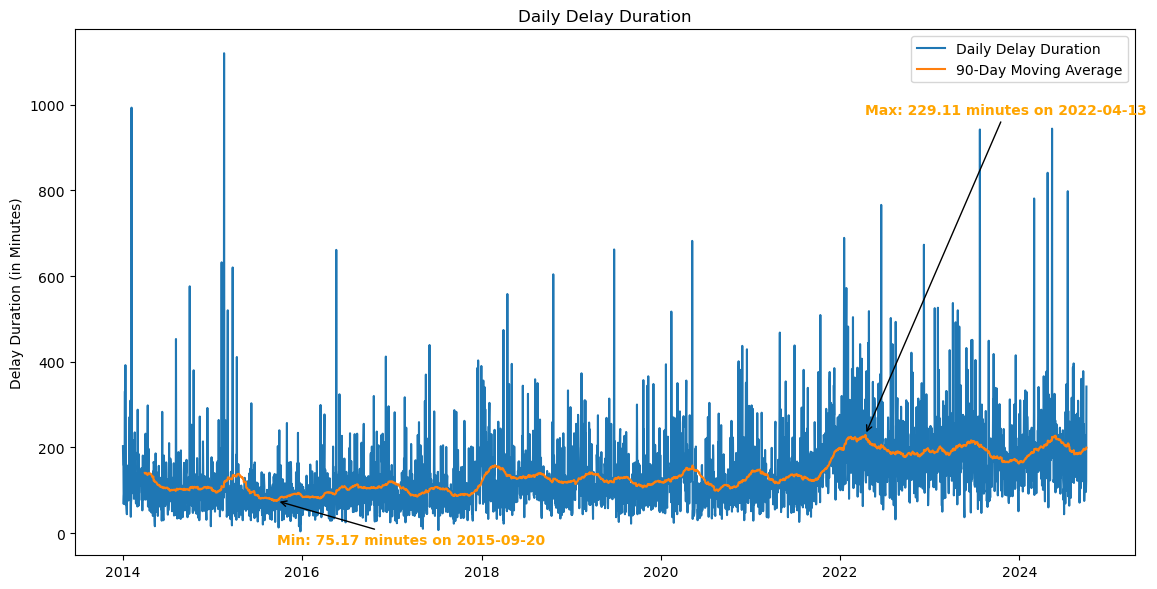

In [132]:
# group by date and sum the delay occurrences
daily_delay_duration = df_master.groupby('Date')['Min Delay'].sum().reset_index()
# compute the 90-day moving average
daily_delay_duration['MA90'] = daily_delay_duration['Min Delay'].rolling(window = 90).mean()

# create the line chart
plt.figure(figsize = (12,6))
plt.plot(daily_delay_duration['Date'], 
         daily_delay_duration['Min Delay'], 
         label = 'Daily Delay Duration')
plt.plot(daily_delay_duration['Date'], 
         daily_delay_duration['MA90'], 
         label = '90-Day Moving Average')
plt.title('Daily Delay Duration')
plt.ylabel('Delay Duration (in Minutes)')

# annotate max values
max_date = daily_delay_duration.loc[daily_delay_duration['MA90'].idxmax(), 'Date']
max_delay = daily_delay_duration['MA90'].max()
plt.annotate(f'Max: {max_delay:.2f} minutes on {max_date.strftime("%Y-%m-%d")}',
             xy = (max_date, max_delay), 
             xytext = (max_date, max_delay + 750),
             arrowprops = dict(arrowstyle = '->'), 
             fontsize = 10, 
             color = 'orange', 
             fontweight = 'bold')

# annotate min values
min_date = daily_delay_duration.loc[daily_delay_duration['MA90'].idxmin(), 'Date']
min_delay = daily_delay_duration['MA90'].min()
plt.annotate(f'Min: {min_delay:.2f} minutes on {min_date.strftime("%Y-%m-%d")}',
             xy = (min_date, min_delay), 
             xytext = (min_date, min_delay - 100),
             arrowprops = dict(arrowstyle = '->'), 
             fontsize = 10, 
             color = 'orange', 
             fontweight = 'bold')

plt.legend()
plt.tight_layout()
plt.show()


We see a more conclusive observation here: total delays per day have been lasting longer.

An escalation in the 90-day Moving Average Delay Duration (MADD) was seen in late 2017, which plateaued from early 2018 to the first quarter of 2020. The beginning of the Covid-19 pandemic in the second quarter of 2020 reduced delay durations because of limited subway operations due to lockdowns. However, upon reopening of the economy sometime in late 2021, 90-day MADD began ascending and peaked on February 12, 2022 at 229.11 minutes (3.8 hours) on a single day. The 90-day MADD plateaued once more after this date, notably at a higher level compared to that during the pandemic and pre-pandemic periods.

## Time of Delay

Total of delay durations by minute.

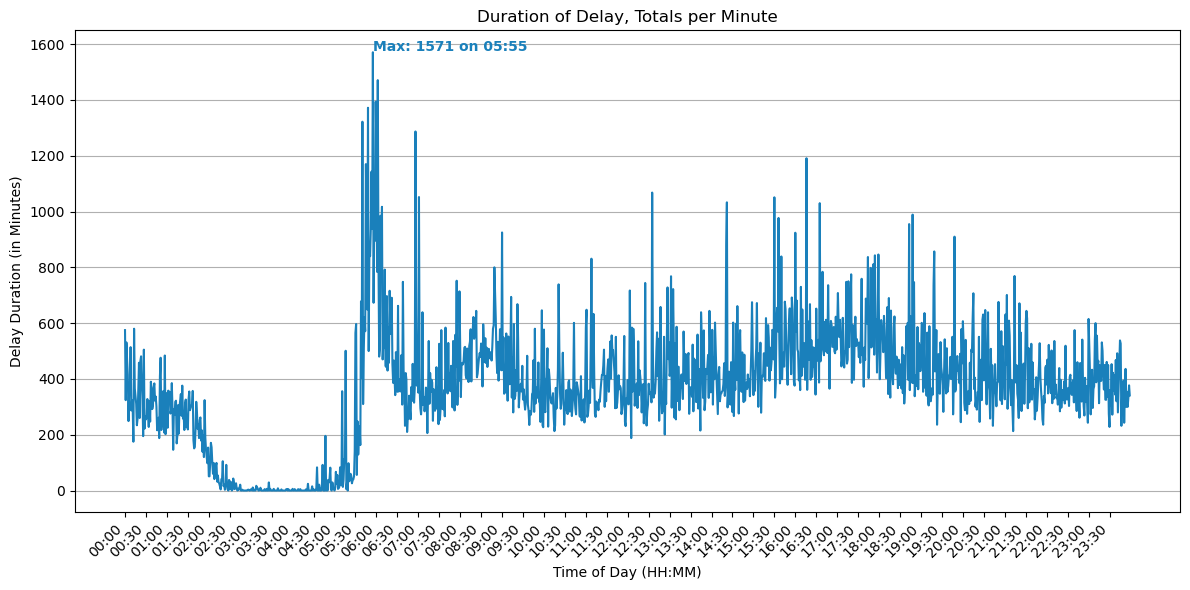

In [133]:
# group by time and sum the delay duration
delay_duration_per_minute = df_master.groupby('Time')['Min Delay'].sum().reset_index()

# create the line chart
plt.figure(figsize=(12, 6))
plt.plot(delay_duration_per_minute['Time'], 
         delay_duration_per_minute['Min Delay'], 
         color='#1a80bb')
plt.title('Duration of Delay, Totals per Minute')
plt.xlabel('Time of Day (HH:MM)')
plt.xticks(delay_duration_per_minute['Time'][::30], rotation = 45, ha = 'right')
plt.ylabel('Delay Duration (in Minutes)')
plt.grid(axis = 'y')

# maximum data annotation
max_time = delay_duration_per_minute.loc[delay_duration_per_minute['Min Delay'].idxmax(), 'Time']
max_delay = delay_duration_per_minute['Min Delay'].max()
plt.annotate(f'Max: {max_delay} on {max_time}',
             xy = (max_time, max_delay), 
             xytext = (max_time, max_delay + 5),
             fontsize = 10, 
             color = '#1a80bb', 
             fontweight = 'bold')

plt.tight_layout()
plt.show()

When delay durations are totaled per minute, 05:55 (5:55 am) had the longest delays. This is a critical time for TTC commuters as this may represent a time when people are on their way to their workplaces.

## Delay Causes

One of the primary objectives of this paper is to determine whether we can improve the efficiency and reliability of the TTC Subway System. As shown previously, there are 200 delay causes identified by the TTC in its excel file (they separated the delay causes between Lines 1, 2, and 4, and Line 3; a number of causes are identical between them), out of which 143 were present in the cleaned dataset. This poses a huge problem in our data analysis.

In [134]:
# group by delay_cause and create a table with count, sum, average, and delay_category
grouped_delay_causes = df_master.groupby('delay_cause').agg(
    total_occurrence = ('Min Delay', 'count'),
    delay_duration = ('Min Delay', 'sum'),
    delay_category = ('delay_category', 'first')).reset_index()
grouped_delay_causes['average_delay'] = grouped_delay_causes['delay_duration'] / grouped_delay_causes['total_occurrence']
grouped_delay_causes

,delay_cause,total_occurrence,delay_duration,delay_category,average_delay
0,ATC Operator Related,342,1467,Personnel Related,4.289474
1,ATC Project,3302,15434,Equipment Related,4.674137
2,ATC RC&S Equipment,124,644,Equipment Related,5.193548
3,ATC Signals Other,54,132,Equipment Related,2.444444
4,Air Conditioning,361,1518,Equipment Related,4.204986
...,...,...,...,...,...
138,Work Refusal,221,786,Personnel Related,3.556561
139,Work Vehicle,153,1993,Equipment Related,13.026144
140,Work Zone Problems - Signals,105,562,Equipment Related,5.352381
141,Work Zone Problems - Track,581,6020,Equipment Related,10.361446


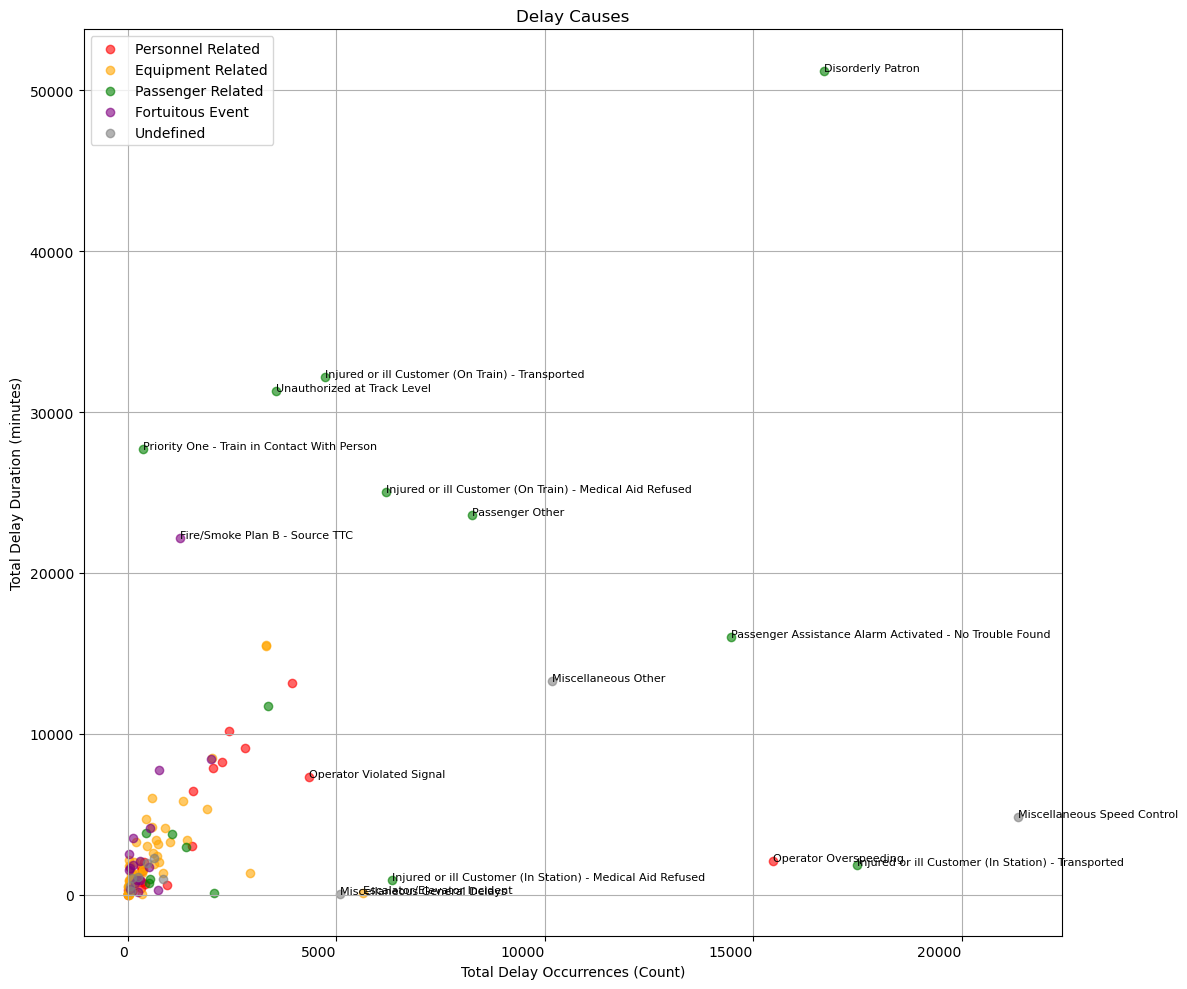

In [135]:
# create scatterplot per delay_cause and implement color scheme per delay_category
plt.figure(figsize = (12, 10))
for category, color in colors.items():
    subset = grouped_delay_causes[grouped_delay_causes['delay_category'] == category]
    plt.scatter(subset['total_occurrence'],
                subset['delay_duration'],
                #s = subset['average_delay'] * 10,
                alpha = 0.6,
                label = category,
                c = color)

# annotate data that meets criteria below
for i, row in grouped_delay_causes[
    (grouped_delay_causes['total_occurrence'] > 4000) |
    (grouped_delay_causes['delay_duration'] > 20000)].iterrows():
    plt.annotate(row['delay_cause'], 
                (row['total_occurrence'], row['delay_duration']), 
                fontsize = 8)

plt.title('Delay Causes')
plt.xlabel('Total Delay Occurrences (Count)')
plt.ylabel('Total Delay Duration (minutes)')
plt.xticks(rotation = 0, ha = 'right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Here we classify delays in terms of risk management:
1. Unlikely Bother, or Low-Likelihood Low-Severity delays
 - These are delay causes that are not frequent and also with low delay duration. They almost never happen and, if they do, have very little impact and can easily be rectified. In our scatterplot above, these are the delay causes that occupy the lower left quadrant (less than 20,000 minutes duration and less than 10,000 occurrences): 'Operator Violated Signal', 'Injured or ill Customer (in Station) - Medical Aid Refused', 'Escalator/Elevator Incident', etc. We can see from our plot above that majority of recorded delays fall within this classification.

2. Frequent Nuisance, or High-Likelihood Low-Severity delays
 - These are delay causes that are frequent but with low delay duration. These include minor equipment malfunctions that are resolved quickly, routine maintenance issues, etc. In our scatterplot above, these are the delay causes that occupy the lower right quadrant (less than 20,000 minutes duration and more than 10,000 occurrences): 'Miscellaneous Speed Control', 'Operator Overspeeding', 'Injured or ill Customer (In Station) - Transported', 'Passenger Assistance Alarm Activated - No Trouble Found', 'Miscellaneous Other', etc.

3. Black Swans, or Low-Likelihood High-Severity delays
 - In risk management, this is any event that is rare but with severe consequences. Delay causes that are low in terms of delay occurrence but high in delay duration (more than 20,000 minutes duration and less than 10,000 occurrences) are considered Black Swans: 'Injured or ill Customer (On Train) - Medical Aid Refused', 'Injured or ill Customer (On Train) - Transported', 'Unauthorized at Track Level', 'Priority One - Train in Contact with Person', etc.

4. Critical Risk, or High-Likelihood High-Severity delays
 - These are events that are high in both frequency and duration (more than 20,000 minutes duration and more than 10,000 occurrences). A single delay cause falls in this classification: 'Disorderly Patron'.



## Delay Categories

In [136]:
# group into delay category and per month
grouped_delay_category = df_master.groupby([
        df_master['delay_category'],
        df_master['datetime'].dt.to_period('M').dt.to_timestamp()
    ]).agg(
        total_occurrence = ('Min Delay', 'count'),
        delay_duration = ('Min Delay', 'sum')).reset_index()
grouped_delay_category['average_delay'] = grouped_delay_category['delay_duration'] / grouped_delay_category['total_occurrence']
grouped_delay_category['3-Month MA'] = grouped_delay_category['delay_duration'].rolling(window = 3).mean()
grouped_delay_category

,delay_category,datetime,total_occurrence,delay_duration,average_delay,3-Month MA
0,Equipment Related,2014-01-01,372,1467,3.943548,NaN
1,Equipment Related,2014-02-01,293,1054,3.597270,NaN
2,Equipment Related,2014-03-01,347,1385,3.991354,1302.000000
3,Equipment Related,2014-04-01,287,1112,3.874564,1183.666667
4,Equipment Related,2014-05-01,292,992,3.397260,1163.000000
...,...,...,...,...,...,...
640,Undefined,2024-05-01,219,274,1.251142,238.333333
641,Undefined,2024-06-01,175,195,1.114286,227.000000
642,Undefined,2024-07-01,206,184,0.893204,217.666667
643,Undefined,2024-08-01,301,517,1.717608,298.666667


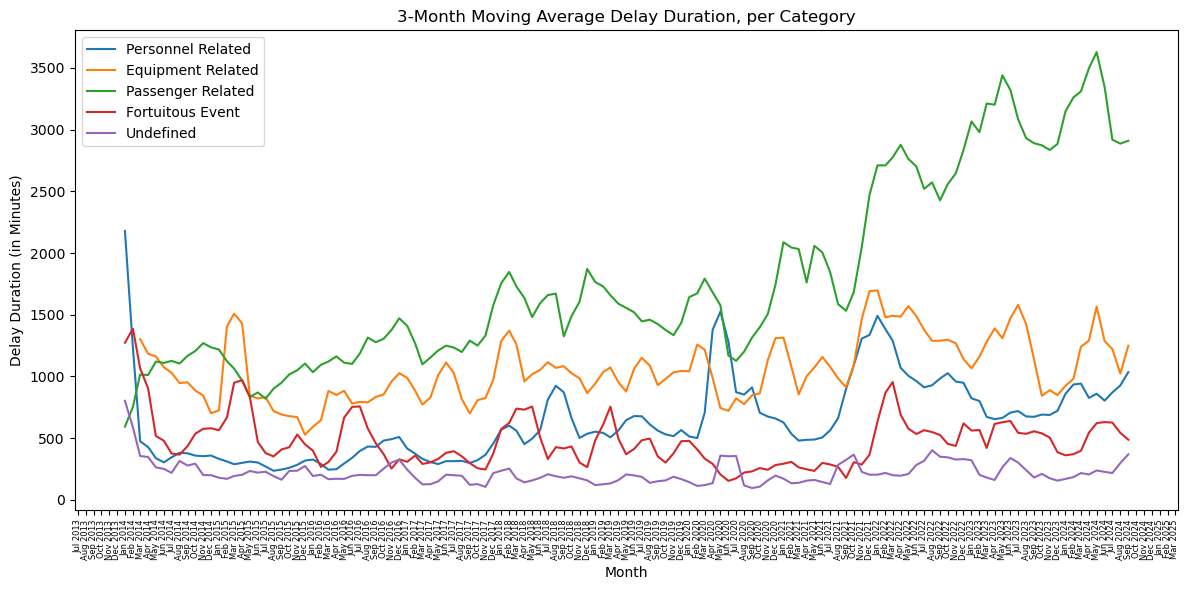

In [137]:
# plot in a line chart to look for trends per delay category using 3-month averages
plt.figure(figsize = (12,6))
for category, color in colors.items():
    subset = grouped_delay_category[grouped_delay_category['delay_category'] == category]
    plt.plot(subset['datetime'], 
             subset['3-Month MA'], 
             label = category)
    
plt.title('3-Month Moving Average Delay Duration, per Category')
plt.xlabel('Month')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation = 90, fontsize = 6)
plt.ylabel('Delay Duration (in Minutes)')
plt.legend()
plt.tight_layout()
plt.show()

Four (4) categories led the initial spike in late 2021: Fortuitous Event, Personnel Related, Equipment Related, and Passenger Related. However, three (3) of the four (4) have since slowly tapered down, save for Passenger Related whose trend continues to worsen.

We can conclude from the above line chart that the worsening 90-day MADD since late 2021 was primarily caused by the worsening of the duration of Passenger-Related delays, as seen in the 3-month MADD above. 

## Passenger Related Category

In [138]:
grouped_passenger = Passenger_Related.groupby([
    Passenger_Related['delay_cause'],
    Passenger_Related['datetime'].dt.to_period('M').dt.to_timestamp()]).agg(
        total_occurrence = ('Min Delay', 'count'),
        delay_duration = ('Min Delay', 'sum')).reset_index()
grouped_passenger['average_delay'] = grouped_passenger['delay_duration'] / grouped_passenger['total_occurrence']
grouped_passenger['3-Month MA'] = grouped_passenger['delay_duration'].rolling(window = 3).mean()
grouped_passenger

,delay_cause,datetime,total_occurrence,delay_duration,average_delay,3-Month MA
0,Assault / Employee Involved,2014-01-01,8,9,1.125000,NaN
1,Assault / Employee Involved,2014-02-01,5,6,1.200000,NaN
2,Assault / Employee Involved,2014-03-01,6,11,1.833333,8.666667
3,Assault / Employee Involved,2014-04-01,10,26,2.600000,14.333333
4,Assault / Employee Involved,2014-05-01,6,0,0.000000,12.333333
...,...,...,...,...,...,...
2014,Unauthorized at Track Level,2024-05-01,64,457,7.140625,545.666667
2015,Unauthorized at Track Level,2024-06-01,57,439,7.701754,522.666667
2016,Unauthorized at Track Level,2024-07-01,46,364,7.913043,420.000000
2017,Unauthorized at Track Level,2024-08-01,50,343,6.860000,382.000000


In [139]:
grouped_passenger_delay_cause = grouped_passenger.groupby('delay_cause').agg(
        total_occurrence = ('total_occurrence', 'sum'),
        delay_duration = ('delay_duration', 'sum')).reset_index()
grouped_passenger_delay_cause

,delay_cause,total_occurrence,delay_duration
0,Assault / Employee Involved,1401,2962
1,Assault / Patron Involved,3358,11714
2,Disorderly Patron,16704,51237
3,Door Problems - Passenger Related,1054,3775
4,Held By Polce - Non-TTC Related,431,3846
5,Injured or ill Customer (In Station) - Medical...,6321,918
6,Injured or ill Customer (In Station) - Transpo...,17496,1822
7,Injured or ill Customer (On Train) - Medical A...,6196,25031
8,Injured or ill Customer (On Train) - Transported,4735,32174
9,Passenger Assistance Alarm Activated - No Trou...,14462,15984


### Monthly Delay Duration, Passenger Related Delay Causes

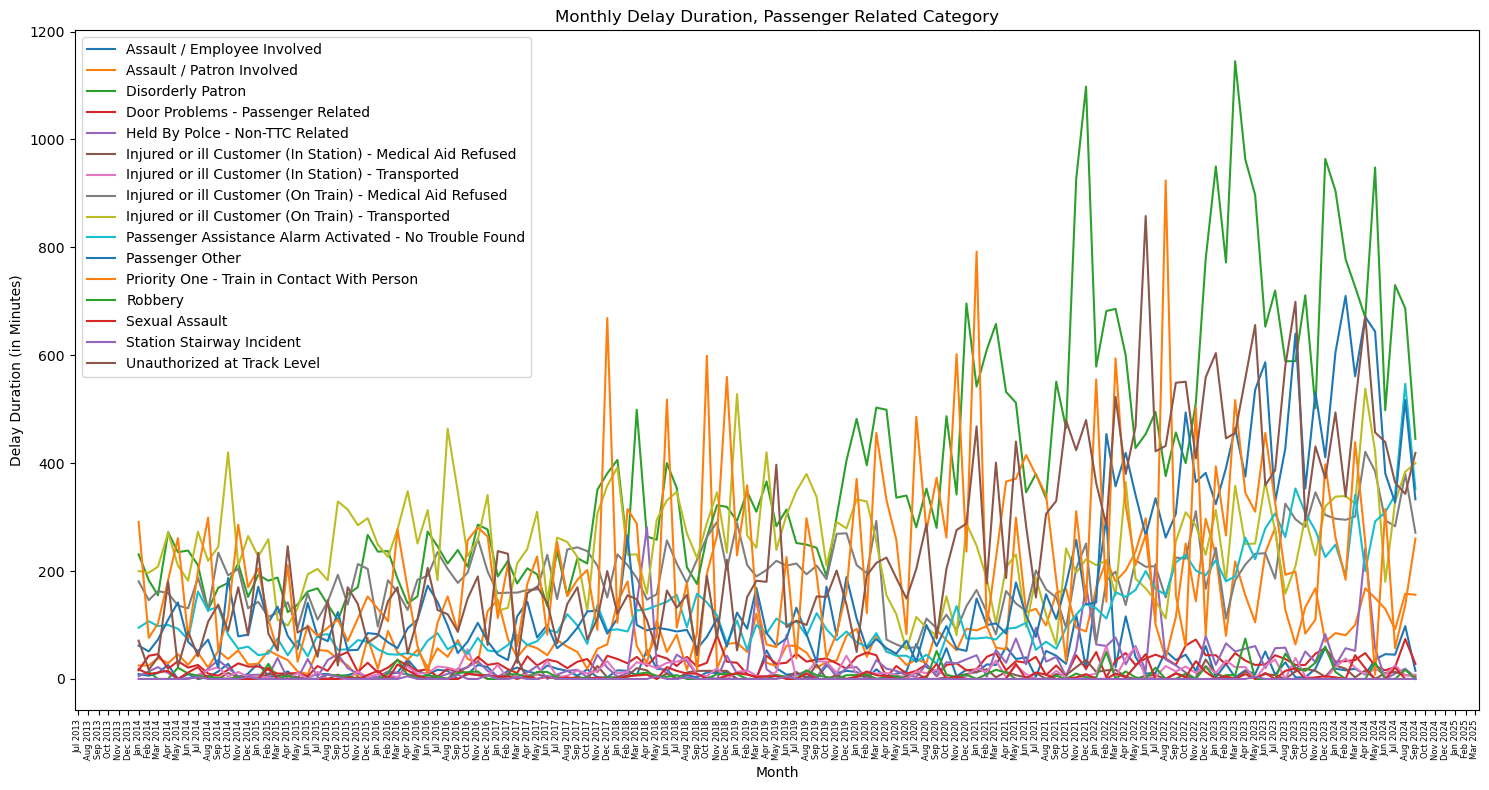

In [140]:
# plot in a line chart all the delay causes under Passenger Related category to see monthly trends
plt.figure(figsize = (15,8))
for cause in grouped_passenger['delay_cause'].unique():
    subset = grouped_passenger[grouped_passenger['delay_cause'] == cause]
    plt.plot(subset['datetime'],
             subset['delay_duration'],
             label = cause)
    
plt.title('Monthly Delay Duration, Passenger Related Category')
plt.xlabel('Month')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation = 90, fontsize = 6)
plt.ylabel('Delay Duration (in Minutes)')
plt.legend()
plt.tight_layout()
plt.show()

There are 16 delay causes under the Passenger Related category. Visually, the above chart is extremely cluttered.

### Linear Regression on Delay Causes under Passenger Related Category

Aside from visually assessing the trend of each delay cause, we can also mathematically check if the delay duration per delay cause is actually getting worse or better. We do this through linear regression. Here, we assign the month as the independent variable and the delay duration as the dependent variable.

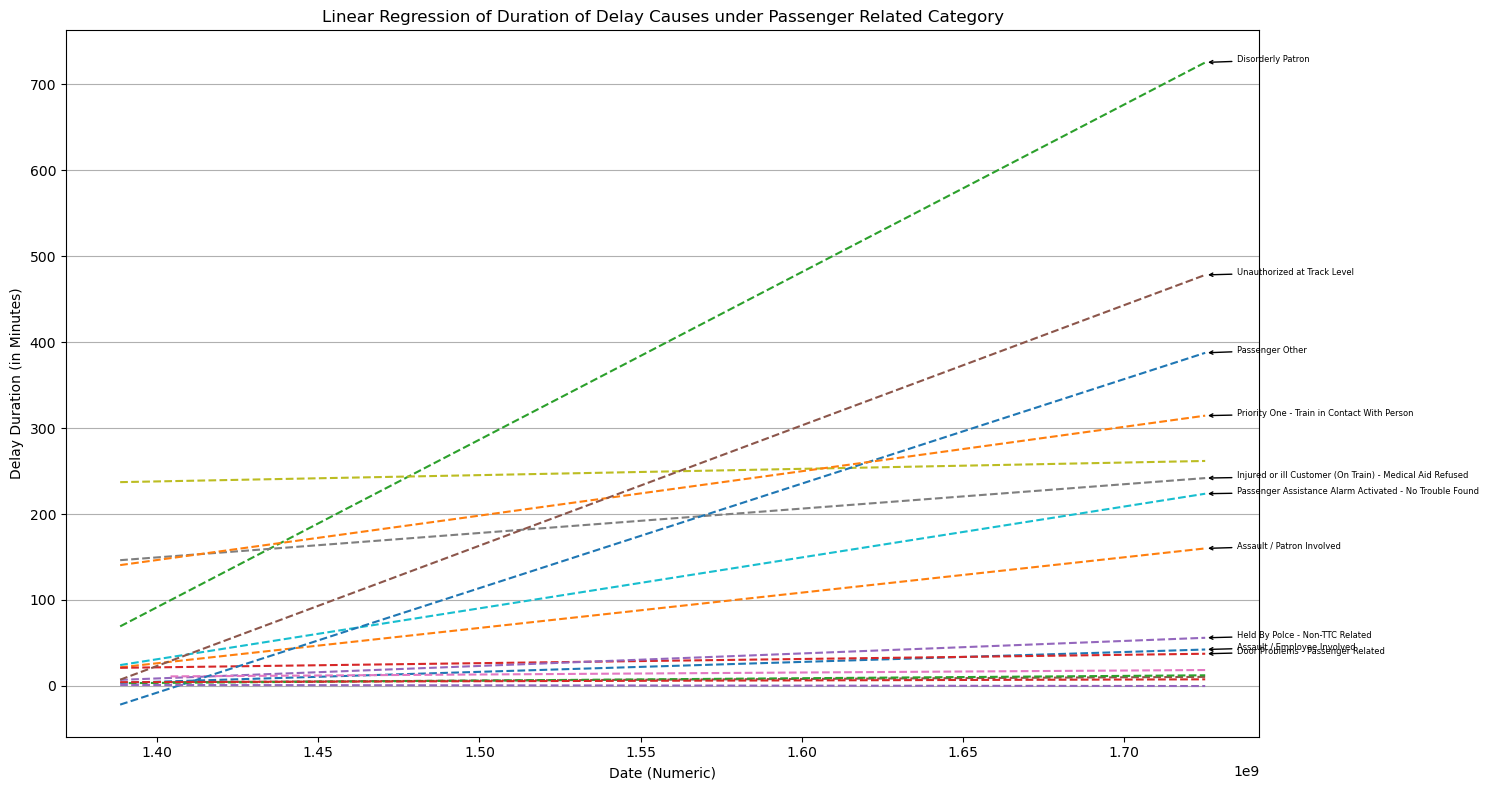

In [141]:
# create a new column to convert datetime column from datetime data type to numeric data type
grouped_passenger['datetime_numeric'] = grouped_passenger['datetime'].apply(lambda x: x.timestamp())
# perform linear regression
results_passenger = []
plt.figure(figsize = (15, 8))
for cause in grouped_passenger['delay_cause'].unique():
    subset = grouped_passenger[grouped_passenger['delay_cause'] == cause]
    slope, intercept, r_value, p_value, std_err = linregress(subset['datetime_numeric'], subset['delay_duration'])
    predicted_y = slope * subset['datetime_numeric'] + intercept
    significance = 'Y' if p_value < 0.05 else 'N'
    strong_significance = 'Y' if p_value < 0.01 else 'N'
    
    # create a table
    results_passenger.append({
        'delay_cause': cause,
        'slope': slope,
        'intercept': intercept,
        'r-value': r_value,
        'p-value': p_value,
        'std_err': std_err,
        'pval < 0.05': significance,
        'pval < 0.01': strong_significance})
    
    # plot the regression line per delay cause
    plt.plot(subset['datetime_numeric'], 
             predicted_y, 
             label = f'{cause} - Regression Line', 
             linestyle = '--')

# create a dataframe from the list to enable sorting of values
results_passenger = pd.DataFrame(results_passenger)
results_passenger10 = results_passenger[results_passenger['pval < 0.01'] == 'Y'].sort_values(by = 'slope', ascending = False).head(10)

# annotate the top 10 delay causes in terms of slope (only label causes which are strongly statistically significant)
for i, row in results_passenger10.iterrows():
    subset = grouped_passenger[grouped_passenger['delay_cause'] == row['delay_cause']]
    max_x = subset['datetime_numeric'].max()
    max_y = row['slope'] * max_x + row['intercept']

    plt.annotate(f"{row['delay_cause']}",
                 xy = (max_x, max_y), 
                 xytext = (max_x + 10000000, max_y + 0),
                 arrowprops = dict(arrowstyle = "->", color = 'black'),
                 fontsize = 6)

plt.xlabel('Date (Numeric)')
plt.ylabel('Delay Duration (in Minutes)')
plt.title('Linear Regression of Duration of Delay Causes under Passenger Related Category')
plt.grid(axis = 'y')
#plt.legend()
plt.tight_layout()
plt.show()

A positive slope indicates that the delay duration is getting worse. A negative slope indicates that it is getting better.
A p-value of less than 0.05 means that the change (i.e. the slope, whether positive or negative) is statistically significant. A p-value of equal or more than 0.05 means that the delay duration is getting worse due to random chance.

In [142]:
results_passenger.sort_values(by = 'slope', ascending = False)

,delay_cause,slope,intercept,r-value,p-value,std_err,pval < 0.05,pval < 0.01
2,Disorderly Patron,1.948996e-06,-2636.949192,0.807354,6.995478e-31,1.263998e-07,Y,Y
15,Unauthorized at Track Level,1.398944e-06,-1935.226845,0.783184,5.571025e-28,9.855483e-08,Y,Y
10,Passenger Other,1.215783e-06,-1709.877352,0.722074,4.638521e-22,1.033625e-07,Y,Y
9,Passenger Assistance Alarm Activated - No Trou...,5.921708e-07,-797.965583,0.675671,1.581553e-18,5.733195e-08,Y,Y
11,Priority One - Train in Contact With Person,5.164660e-07,-576.549940,0.300947,7.960453e-04,1.500248e-07,Y,Y
1,Assault / Patron Involved,4.109171e-07,-548.896396,0.502606,1.284237e-09,6.271874e-08,Y,Y
7,Injured or ill Customer (On Train) - Medical A...,2.837649e-07,-247.717387,0.404959,1.933763e-06,5.685276e-08,Y,Y
4,Held By Polce - Non-TTC Related,1.454346e-07,-194.882937,0.311409,6.317027e-04,4.138456e-08,Y,Y
0,Assault / Employee Involved,1.153402e-07,-156.596693,0.325986,1.632704e-04,2.968140e-08,Y,Y
8,Injured or ill Customer (On Train) - Transported,7.318703e-08,135.475634,0.077593,3.821053e-01,8.344502e-08,N,N


Looking at the above, we can see that Disorderly Patron had the highest slope with a P-value of less than 0.01, indicating that there is strong statistical significance (i.e. it's not due to random chance).

### Disorderly Patron

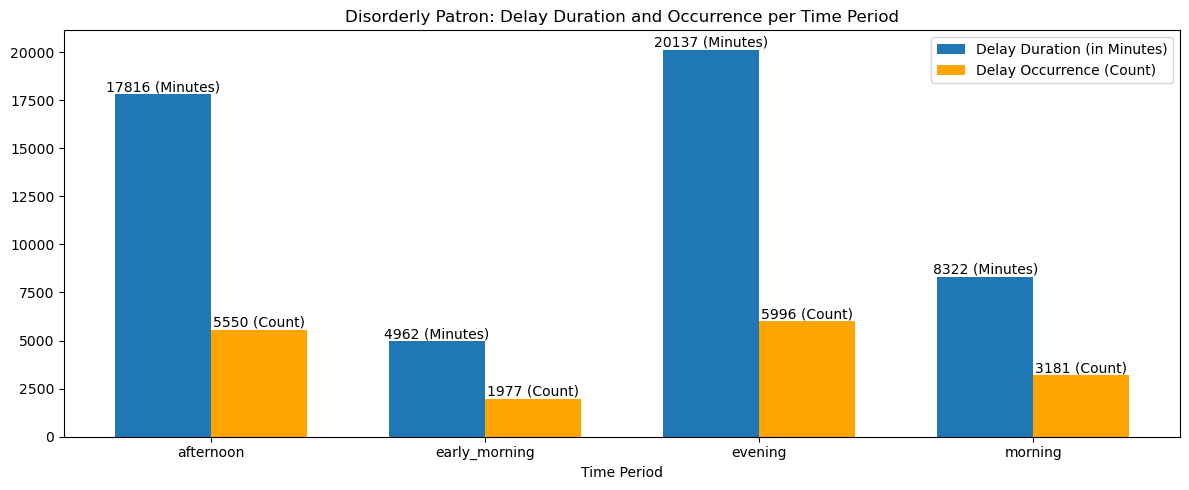

In [143]:
create_bar_chart(delay_cause = Disorderly_Patron,
                 title = 'Disorderly Patron: Delay Duration and Occurrence per Time Period')

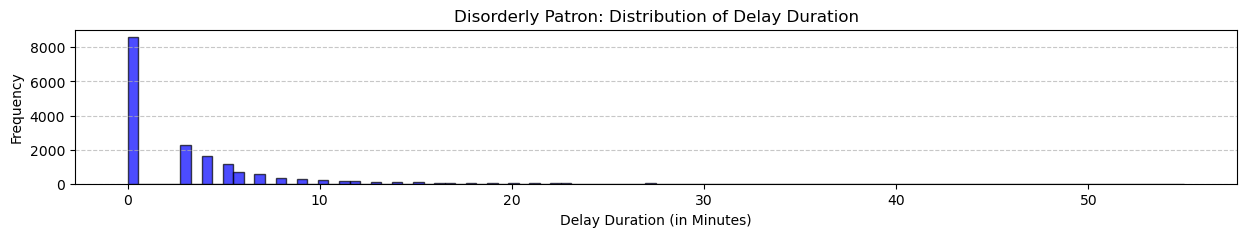

In [155]:
create_histogram(delay_cause = Disorderly_Patron,
                 title = 'Disorderly Patron: Distribution of Delay Duration')

### Unauthorized at Track Level

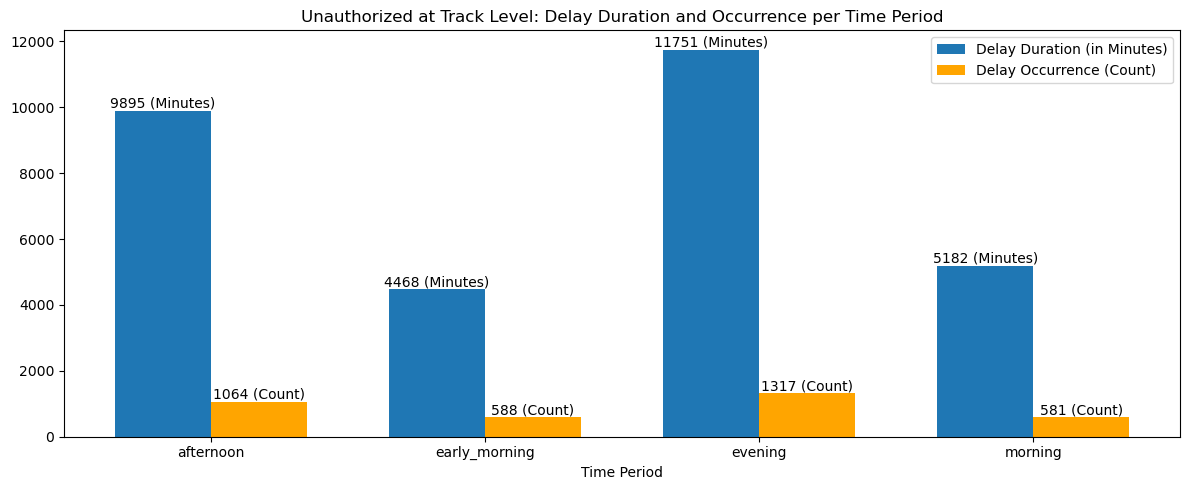

In [145]:
create_bar_chart(delay_cause = Unauthorized_at_Track_Level,
                 title = 'Unauthorized at Track Level: Delay Duration and Occurrence per Time Period')

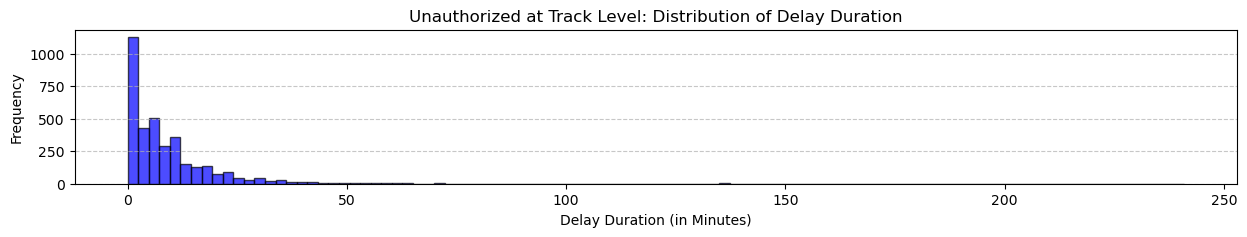

In [156]:
create_histogram(delay_cause = Unauthorized_at_Track_Level,
                 title = 'Unauthorized at Track Level: Distribution of Delay Duration')

### Passenger Other

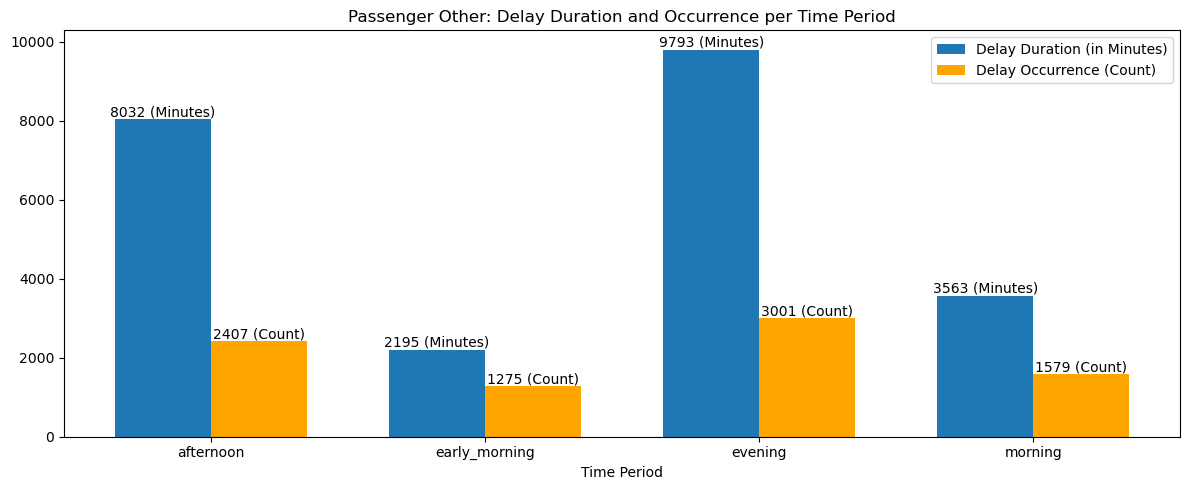

In [157]:
create_bar_chart(delay_cause = Passenger_Other,
                 title = 'Passenger Other: Delay Duration and Occurrence per Time Period')

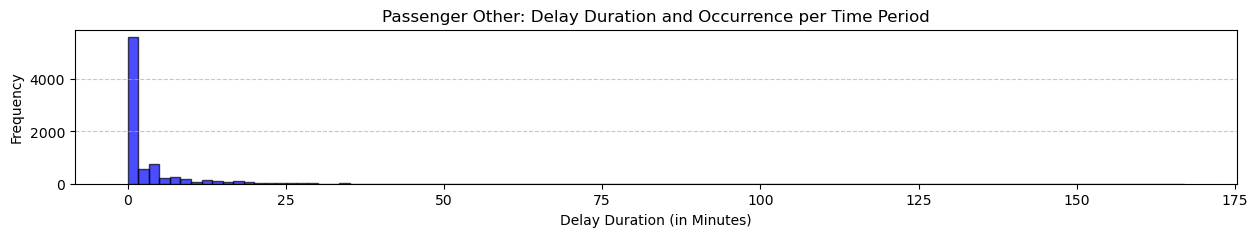

In [158]:
create_histogram(delay_cause = Passenger_Other,
                 title = 'Passenger Other: Delay Duration and Occurrence per Time Period')

### Passenger Assistance Alarm Activated - No Trouble Found

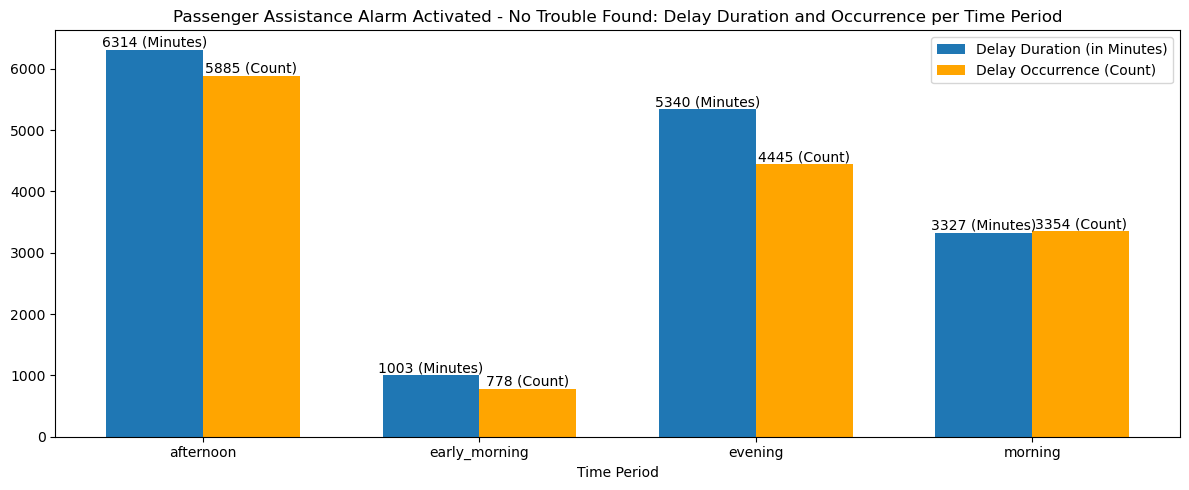

In [159]:
create_bar_chart(delay_cause = Passenger_Assistance_Alarm_Activated___No_Trouble_Found,
                 title = 'Passenger Assistance Alarm Activated - No Trouble Found: Delay Duration and Occurrence per Time Period')

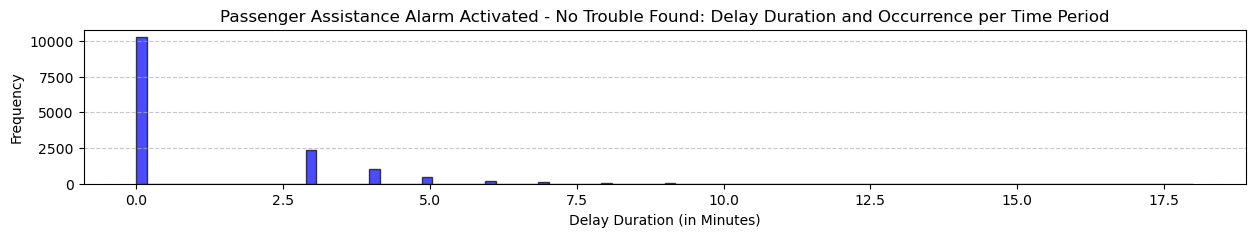

In [160]:
create_histogram(delay_cause = Passenger_Assistance_Alarm_Activated___No_Trouble_Found,
                 title = 'Passenger Assistance Alarm Activated - No Trouble Found: Delay Duration and Occurrence per Time Period')

### Priority One - Train in Contact with Person

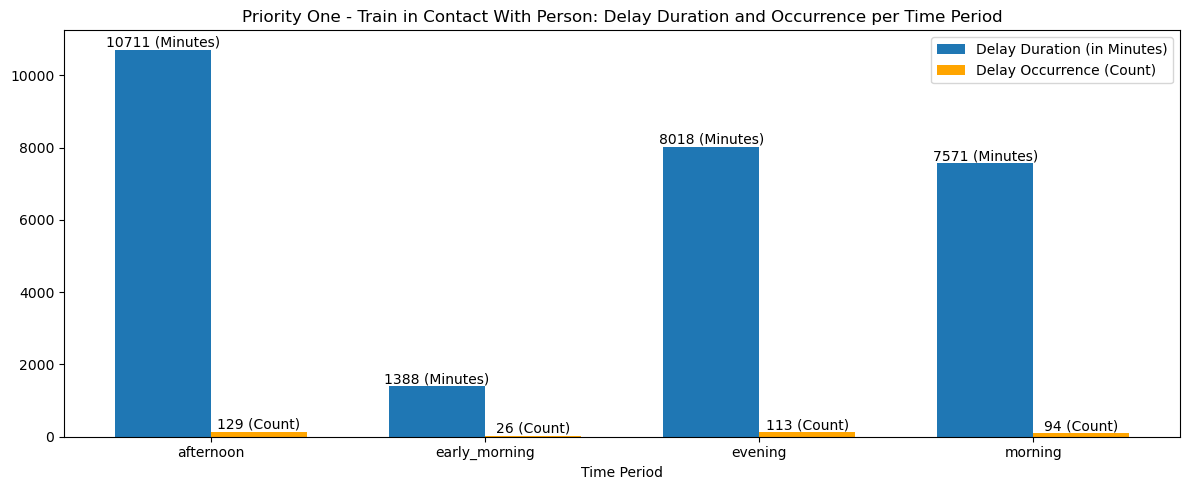

In [161]:
create_bar_chart(delay_cause = Priority_One___Train_in_Contact_With_Person,
                 title = 'Priority One - Train in Contact With Person: Delay Duration and Occurrence per Time Period')

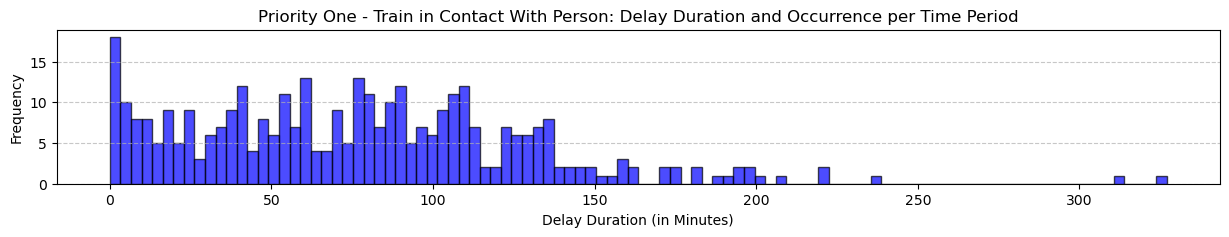

In [162]:
create_histogram(delay_cause = Priority_One___Train_in_Contact_With_Person,
                 title = 'Priority One - Train in Contact With Person: Delay Duration and Occurrence per Time Period')

### Findings: Passenger Related Category

1. Disorderly Patrons have been the number 1 cause of the increasing delay durations of the TTC.
- Disorderly Patrons are delays caused by commuters misbehaving. This may include fighting or any other behavior that disturbs other patrons while on the train. 
- This was classified as a Category 4 Risk (Critical Risk, or High-Likelihood High-Severity delays).
- The worsening delay duration of this particular cause has been found to be strongly statistically significant and not due to random chance.
- This often occurred during the evening (18:00 to 23:59), followed by the afternoon (12:00 to 17:59). Likewise, longer delay durations, were found in the evenings followed by the afternoon.